## This is a Deep Learning Classifier using the ResNet50 Model


Steps Taken:

- Data Loading: Loads the Breast Cancer Ultrasound Images Dataset from Hugging Face.
- Data Preprocessing: Define transformations to be applied to the images, including resizing, random horizontal flipping, random rotation, and normalization.
- Data Split: Splitting the dataset into training and validation sets (80% for training and 20% for validation).
- Model Definition: Define a ResNet50 model with a custom fully connected layer to match the number of classes in the dataset.
- Training: Train the model using the training set and evaluates its performance on the validation set.
- Evaluation: Evaluate the model's performance using metrics such as accuracy, precision, recall, and F1-score.




#### The goal is to develop a image classification pipeline using a pre-trained ResNet50 model and evaluate its performance on the Breast Cancer Ultrasound Images Dataset.

#### Step 1: Install and import the necessary libraries

These libraries are necessary for the project because they provide the building blocks for the image classification pipeline. Specifically:

- torch and torchvision are used for building and training the neural network model.
- datasets is used to load and manipulate the Breast Cancer Ultrasound Images Dataset.
- pillow is used to handle image processing tasks, such as resizing and normalizing images.
- sklearn is used for evaluating the performance of the model using metrics such as accuracy, precision, recall, and F1-score.





In [5]:
from tensorflow.python.framework.test_util import gpu_device_name
%pip install torch torchvision datasets pillow sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

In [4]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import models
import os
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix

#### Step 2: Loading and Organising the Dataset

We load the Breast Cancer Ultrasound Images Dataset and organize it into the following directories:

- Base Directory: breast_ultrasound_data
- Split Directories: train, test, and validation
- Label Subdirectories: 0 (normal), 1 (benign), and 2 (malignant)

We save each image in the dataset to its corresponding label subdirectory, using a unique filename based on the image index.

In [12]:
# Load the dataset
dataset = load_dataset("gymprathap/Breast-Cancer-Ultrasound-Images-Dataset")

# Define the base directory to store images
base_dir = 'breast_ultrasound_data'
os.makedirs(base_dir, exist_ok=True)

# Organize dataset into needed directories
for split in dataset.keys():  # `train`, `test`, and `validation` splits
    split_dir = os.path.join(base_dir, split)
    os.makedirs(split_dir, exist_ok=True)

    for idx, record in enumerate(dataset[split]):
        try:
            label = record['label']  #  0 (normal), 1 (benign), 2 (malignant)
            label_dir = os.path.join(split_dir, str(label))
            os.makedirs(label_dir, exist_ok=True)
    
            # Save image using the index to ensure unique filenames
            image = record['image']
            image.save(os.path.join(label_dir, f"{idx}.png"))
        except Exception as error:
            print(f"Error saving image {idx}: {error}")



#### Step 3: Set up image preprocessing and data loaders

In this section, we define the transformations to be used on the photos, load the dataset, and divide it into training and validation sets.

We then define the data loaders for the training and validation sets, which will be used to input data into the model while training.

In [13]:
# Set up image preprocessing
img_height, img_width = 224, 224
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset and split into train and validation sets
train_data = ImageFolder(os.path.join(base_dir, 'train'), transform=transform)
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Set up data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


#### Step 4: Loading and Configuring the ResNet Model

We load a pre-trained ResNet50 model. 


We freeze the base model layers. This means that the weights of these layers will not be updated during training, and the model will only learn to adjust the weights of the fully connected layer.


We modify the fully connected layer to match our number of classes (3). We create a new fully connected layer with the same input features as the original layer, but with an output size of 3. We assign this new layer to the fc attribute of the model.


Attempt to move the model to GPU if available. 


In [20]:
# Load pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# Freeze the base model layers
for param in model.parameters():
    param.requires_grad = False

# Modify the fully connected layer
num_classes = 3
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Attempt to move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



#### Step 5: Define the Loss Function and Optimizer
The loss function is defined as CrossEntropyLoss(), which is a common loss function used for multi-class classification problems.This loss function calculates the difference between the model's predictions and the actual labels, and returns a loss value that represents the error.


The optimizer is defined as Adam, which is a popular optimization algorithm used for training deep learning models. The learning rate is set to 0.001, which controls how quickly the optimizer updates the model's parameters during training.


By only optimizing the parameters of the fully connected layer, we are effectively freezing the weights of the pre-trained ResNet50 model and only training the weights of the fully connected layer.


In [21]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)




#### Step 6: Training the Model

The model is trained for 20 epochs, and the loss and accuracy are recorded for each epoch. The model is then evaluated on the validation set and the loss and accuracy are recorded for each epoch. 

In [22]:
# Training loop
num_epochs = 20
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average losses
    train_loss = running_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")


Epoch [1/20], Train Loss: 0.8386, Validation Loss: 0.7245, Accuracy: 70.25%
Epoch [2/20], Train Loss: 0.5810, Validation Loss: 0.5656, Accuracy: 75.95%
Epoch [3/20], Train Loss: 0.5243, Validation Loss: 0.6184, Accuracy: 72.47%
Epoch [4/20], Train Loss: 0.5422, Validation Loss: 0.4621, Accuracy: 79.75%
Epoch [5/20], Train Loss: 0.4380, Validation Loss: 0.4241, Accuracy: 81.96%
Epoch [6/20], Train Loss: 0.4281, Validation Loss: 0.4875, Accuracy: 79.11%
Epoch [7/20], Train Loss: 0.4540, Validation Loss: 0.4244, Accuracy: 81.96%
Epoch [8/20], Train Loss: 0.4408, Validation Loss: 0.4567, Accuracy: 79.75%
Epoch [9/20], Train Loss: 0.4160, Validation Loss: 0.3878, Accuracy: 83.23%
Epoch [10/20], Train Loss: 0.4140, Validation Loss: 0.4202, Accuracy: 82.59%
Epoch [11/20], Train Loss: 0.3923, Validation Loss: 0.4037, Accuracy: 82.28%
Epoch [12/20], Train Loss: 0.4207, Validation Loss: 0.4329, Accuracy: 81.65%
Epoch [13/20], Train Loss: 0.4083, Validation Loss: 0.3956, Accuracy: 81.96%
Epoch [1


#### Step 7: Fine-tuning the Model

The model is now trained for 10 more epochs, and the loss and accuracy are recorded for each epoch. 

We now unfreeze the base model layers and recompile the model with a lower learning rate. By unfreezing the layers and re-training the model with a lower learning rate, the model can learn to recognize the specific features and patterns in the data that are relevant to the task. This lower learning rate helps to prevent the model from overshooting the optimal solution during fine-tuning. 

Fine-tuning helps to improve the performance of the model on the specific task.

In [23]:
# Unfreeze layers and recompile with a lower learning rate
for param in model.parameters():
    param.requires_grad = True

# Reinitialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Fine-tune for additional epochs
fine_tune_epochs = 10
for epoch in range(fine_tune_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average losses
    train_loss = running_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{fine_tune_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

Epoch [1/10], Train Loss: 0.3295, Validation Loss: 0.3147, Accuracy: 87.34%
Epoch [2/10], Train Loss: 0.2828, Validation Loss: 0.2732, Accuracy: 87.03%
Epoch [3/10], Train Loss: 0.2550, Validation Loss: 0.2498, Accuracy: 89.56%
Epoch [4/10], Train Loss: 0.2235, Validation Loss: 0.2246, Accuracy: 91.46%
Epoch [5/10], Train Loss: 0.2065, Validation Loss: 0.2180, Accuracy: 91.14%
Epoch [6/10], Train Loss: 0.2006, Validation Loss: 0.2659, Accuracy: 90.51%
Epoch [7/10], Train Loss: 0.1604, Validation Loss: 0.2197, Accuracy: 90.19%
Epoch [8/10], Train Loss: 0.1297, Validation Loss: 0.2259, Accuracy: 90.82%
Epoch [9/10], Train Loss: 0.1539, Validation Loss: 0.1916, Accuracy: 92.41%
Epoch [10/10], Train Loss: 0.1204, Validation Loss: 0.1820, Accuracy: 93.04%


#### Step 8: Evaluating the Model

Setting the model to evaluation mode and evaluating the model on the validation set.

Using the F1 score and confusion matrix to evaluate the model's performance.

Validation Loss: 0.2327
Validation F1 Score: 0.9132


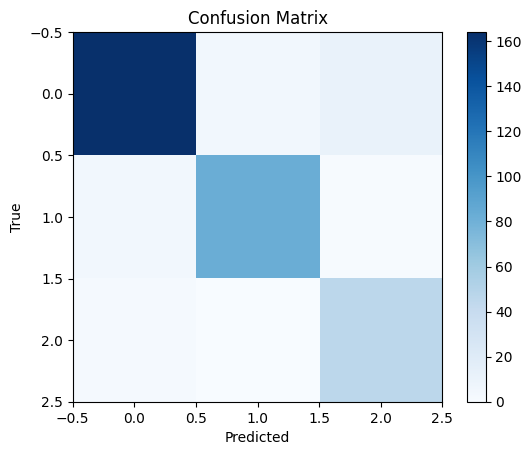

In [24]:
# Set the model to evaluation mode
model = model.eval()
y_true = []
y_pred = []
total_loss = 0.0
criterion = torch.nn.CrossEntropyLoss()

# Validation phase
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # Predicted class
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate average loss and F1 score
avg_loss = total_loss / len(val_loader)
f1 = f1_score(y_true, y_pred, average='macro')
cm = confusion_matrix(y_true, y_pred)

# Display results
print(f"Validation Loss: {avg_loss:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
